# Imports

In [1]:
import pandas as pd
import seaborn as sns
import xgboost as xgb

from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error


pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)

training = True
seed=42

# Functions


In [22]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    if any(y_true == 0):
        output = mean_absolute_error(y_true, y_pred)/ y_true.mean()
    else:
        output = np.mean(np.abs((y_true - y_pred) / y_true))       
    return output*100

# Loading Data

In [3]:
anac_df = pd.read_csv("data.csv", low_memory=False)
feriados = pd.read_csv("feriados.csv")

In [3]:
anac_df.shape

(3549883, 52)

In [4]:
anac_df.head()

,id_basica,sg_empresa_icao,nm_empresa,nm_pais,ds_tipo_empresa,ds_di,ds_grupo_di,ds_tipo_linha,ds_servico_tipo_linha,nr_etapa,nr_ano_partida_real,nm_semestre_partida_real,nm_trimestre_partida_real,hr_partida_real,dt_partida_real,nm_mes_partida_real,nr_mes_partida_real,nm_dia_semana_partida_real,nr_dia_partida_real,sg_iata_origem,nm_pais_origem,nm_regiao_origem,sg_uf_origem,nm_municipio_origem,nr_escala_destino,hr_chegada_real,dt_chegada_real,nm_mes_chegada_real,nr_mes_chegada_real,nm_dia_semana_chegada_real,nr_dia_chegada_real,sg_iata_destino,nm_pais_destino,nm_regiao_destino,sg_uf_destino,nm_municipio_destino,nr_assentos_ofertados,nr_passag_pagos,nr_passag_gratis,sg_equipamento_icao,lt_combustivel,km_distancia,nr_horas_voadas,kg_payload,kg_bagagem_livre,kg_bagagem_excesso,kg_carga_paga,kg_peso,nr_velocidade_media,nr_carga_paga_km,nr_ask,nr_rpk
0,12017235,AZU,AZUL LINHAS AÉREAS BRASILEIRAS S.A.,BRASIL,TRANSPORTE AÉREO REGULAR,REGULAR PREVISTO EM HOTRAN,REGULAR,DOMÉSTICA MISTA,PASSAGEIRO,2,2016.0,1º SEMESTRE,1º TRIMESTRE,06:52:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,THE,BRASIL,NORDESTE,PI,TERESINA,NaN,08:23:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,REC,BRASIL,NORDESTE,PE,RECIFE,118,83,0,E195,3442,937.0,"1,52",16842,1100,6,77,7408,"616,393",72149,110566.0,77771.0
1,12017070,AZU,AZUL LINHAS AÉREAS BRASILEIRAS S.A.,BRASIL,TRANSPORTE AÉREO REGULAR,FRETAMENTO,NÃO REGULAR,DOMÉSTICA MISTA,PASSAGEIRO,1,2016.0,1º SEMESTRE,1º TRIMESTRE,01:43:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,SSA,BRASIL,NORDESTE,BA,SALVADOR,NaN,02:37:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,IOS,BRASIL,NORDESTE,BA,ILHÉUS,70,0,0,AT72,684,225.0,"0,9",7435,0,0,0,0,"250,491",0,15750.0,0.0
2,12017071,AZU,AZUL LINHAS AÉREAS BRASILEIRAS S.A.,BRASIL,TRANSPORTE AÉREO REGULAR,FRETAMENTO,NÃO REGULAR,DOMÉSTICA MISTA,PASSAGEIRO,1,2016.0,1º SEMESTRE,1º TRIMESTRE,02:58:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,IOS,BRASIL,NORDESTE,BA,ILHÉUS,NaN,04:51:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,MCZ,BRASIL,NORDESTE,AL,RIO LARGO,70,33,0,AT72,1392,687.0,"1,88",7390,592,0,0,3067,"365,32",0,48090.0,22671.0
3,12017072,AZU,AZUL LINHAS AÉREAS BRASILEIRAS S.A.,BRASIL,TRANSPORTE AÉREO REGULAR,FRETAMENTO,NÃO REGULAR,DOMÉSTICA MISTA,PASSAGEIRO,1,2016.0,1º SEMESTRE,1º TRIMESTRE,05:15:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,MCZ,BRASIL,NORDESTE,AL,RIO LARGO,NaN,06:32:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,SSA,BRASIL,NORDESTE,BA,SALVADOR,70,0,0,AT72,911,468.0,"1,28",7535,0,0,0,150,"365,496",0,32760.0,0.0
4,12017082,AZU,AZUL LINHAS AÉREAS BRASILEIRAS S.A.,BRASIL,TRANSPORTE AÉREO REGULAR,EXTRA SEM HOTRAN,NÃO REGULAR,INTERNACIONAL MISTA,PASSAGEIRO,1,2016.0,1º SEMESTRE,1º TRIMESTRE,13:25:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,VCP,BRASIL,SUDESTE,SP,CAMPINAS,NaN,22:24:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,MCO,ESTADOS UNIDOS DA AMÉRICA,NaN,NaN,"ORLANDO, FLORIDA",266,260,6,A332,59747,6792.0,"8,98",49489,4665,0,619,25234,"756,301",4204250,1806670.0,1765920.0


In [5]:
feriados.shape

(57, 3)

In [6]:
feriados.head()

,data,fl_feriado,desc_feriado
0,2016-01-01,1,confraternização universal (feriado nacional)
1,2016-02-09,1,(terça-feira ) – Carnaval (ponto facultativo)
2,2016-02-10,1,(quarta-feira ) – Quarta-feira Cinzas (ponto...
3,2016-03-25,1,(sexta-feira ) – Paixão Cristo (feriado naci...
4,2016-04-21,1,(quinta-feira) – Tirantes (feriado nacional)


# Filter Route CGH - SDU

In [4]:
df_sp = anac_df.query("sg_iata_origem == 'CGH' & sg_iata_destino == 'SDU' & nr_passag_pagos != 0")

In [9]:
df_sp.shape

(79206, 52)

# Feature Engineering

## Holyday Variables

In [5]:
# creating variables for 1 and 2 days before a holyday

feriados['data_d1'] = feriados.data.apply(lambda x: str((datetime.strptime(x, '%Y-%m-%d')- timedelta(days=1)).date()))
feriados['data_d2'] = feriados.data.apply(lambda x: str((datetime.strptime(x, '%Y-%m-%d')- timedelta(days=2)).date()))
feriados['fl_feriado_d1'] = feriados.fl_feriado
feriados['fl_feriado_d2'] = feriados.fl_feriado

In [33]:
feriados.head()

,data,fl_feriado,desc_feriado,data_d1,data_d2,fl_feriado_d1,fl_feriado_d2
0,2016-01-01,1,confraternização universal (feriado nacional),2015-12-31,2015-12-30,1,1
1,2016-02-09,1,(terça-feira ) – Carnaval (ponto facultativo),2016-02-08,2016-02-07,1,1
2,2016-02-10,1,(quarta-feira ) – Quarta-feira Cinzas (ponto...,2016-02-09,2016-02-08,1,1
3,2016-03-25,1,(sexta-feira ) – Paixão Cristo (feriado naci...,2016-03-24,2016-03-23,1,1
4,2016-04-21,1,(quinta-feira) – Tirantes (feriado nacional),2016-04-20,2016-04-19,1,1


In [6]:
# joins with df_sp
df_sp = df_sp.merge(feriados[['data','fl_feriado']], left_on='dt_partida_real', right_on='data', how = 'left')
df_sp = df_sp.merge(feriados[['data_d1','fl_feriado_d1']], left_on='dt_partida_real', right_on='data_d1', how = 'left')
df_sp = df_sp.merge(feriados[['data_d2','fl_feriado_d2']], left_on='dt_partida_real', right_on='data_d2', how = 'left')

In [7]:
# filling nulls
df_sp.fillna(0,inplace=True)

In [8]:
# droping variables

keep_list = ["id_basica",
             "sg_empresa_icao",
             "nr_etapa",
             "hr_partida_real",
             "nr_dia_partida_real",
             "nm_dia_semana_partida_real",
             "nm_mes_partida_real",
             "nr_mes_partida_real",
             "dt_partida_real",
             "fl_feriado",
             "fl_feriado_d1",
             "fl_feriado_d2",
             "hr_chegada_real",
             "nr_dia_chegada_real",
             "nm_dia_semana_chegada_real",
             "dt_chegada_real",
             "nr_ano_partida_real",
             "nr_assentos_ofertados",
             "nr_passag_pagos"]

df_sp = df_sp[keep_list]

## Encoding Categorical Variables

In [9]:
# tranforming hours variables into bins of one hour interval
df_sp['hr_partida_round'] = df_sp.hr_partida_real.apply( lambda x : int(x[:2]))
df_sp['hr_chegada_round'] = df_sp.hr_chegada_real.apply( lambda x : int(x[:2]))

In [10]:
# Encoding days of the week variables
cat_encoding = {"nm_dia_semana_partida_real": {"DOMINGO": 1,"SEGUNDA-FEIRA": 2,"TERÇA-FEIRA": 3,"QUARTA-FEIRA": 4,"QUINTA-FEIRA": 5, "SEXTA-FEIRA": 6, "SÁBADO": 7},
                "nm_dia_semana_chegada_real": {"DOMINGO": 1,"SEGUNDA-FEIRA": 2,"TERÇA-FEIRA": 3,"QUARTA-FEIRA": 4,"QUINTA-FEIRA": 5, "SEXTA-FEIRA": 6, "SÁBADO": 7}}

df_sp.replace(cat_encoding, inplace = True)

In [11]:
# Droping variables
df_sp.drop(['id_basica','sg_empresa_icao','nr_etapa','hr_partida_real','nr_ano_partida_real','dt_chegada_real','hr_chegada_real','nm_mes_partida_real'],axis=1, inplace=True)

## Excess Offer

In [12]:
df_sp['excess_offer'] = df_sp.nr_assentos_ofertados - df_sp.nr_passag_pagos

In [91]:
df_sp.head()

,nr_dia_partida_real,nm_dia_semana_partida_real,nr_mes_partida_real,dt_partida_real,fl_feriado,fl_feriado_d1,fl_feriado_d2,nr_dia_chegada_real,nm_dia_semana_chegada_real,nr_assentos_ofertados,nr_passag_pagos,hr_partida_round,hr_chegada_round,excess_offer
0,2.0,7,1.0,2016-01-02,0.0,0.0,0.0,2.0,7,118,64,14,15,54
1,7.0,5,1.0,2016-01-07,0.0,0.0,0.0,7.0,5,106,81,16,17,25
2,9.0,7,1.0,2016-01-09,0.0,0.0,0.0,9.0,7,118,78,14,16,40
3,16.0,7,1.0,2016-01-16,0.0,0.0,0.0,16.0,7,118,99,14,15,19
4,23.0,7,1.0,2016-01-23,0.0,0.0,0.0,23.0,7,118,104,14,15,14


## Grouping Data into hourly bins

In [13]:
df_sp_grouped = df_sp.groupby(['nr_dia_partida_real','nm_dia_semana_partida_real','nr_mes_partida_real','dt_partida_real','nr_dia_chegada_real','nm_dia_semana_chegada_real','hr_partida_round','fl_feriado','fl_feriado_d1','fl_feriado_d2']).agg(nr_passag_pagos=('nr_passag_pagos', np.sum),
nr_assentos_ofertados=('nr_assentos_ofertados', np.sum), count = ('hr_partida_round', 'count'), excess_offer = ('excess_offer',np.sum)).reset_index()

In [89]:
df_sp_grouped.shape

(23571, 14)

In [90]:
df_sp_grouped.head()

,nr_dia_partida_real,nm_dia_semana_partida_real,nr_mes_partida_real,dt_partida_real,nr_dia_chegada_real,nm_dia_semana_chegada_real,hr_partida_round,fl_feriado,fl_feriado_d1,fl_feriado_d2,nr_passag_pagos,nr_assentos_ofertados,count,excess_offer
0,1.0,1,1.0,2017-01-01,1.0,1,8,1.0,0.0,0.0,60,177,1,117
1,1.0,1,1.0,2017-01-01,1.0,1,9,1.0,0.0,0.0,146,441,3,295
2,1.0,1,1.0,2017-01-01,1.0,1,10,1.0,0.0,0.0,292,465,3,173
3,1.0,1,1.0,2017-01-01,1.0,1,11,1.0,0.0,0.0,180,321,2,141
4,1.0,1,1.0,2017-01-01,1.0,1,12,1.0,0.0,0.0,222,276,2,54


# EDA

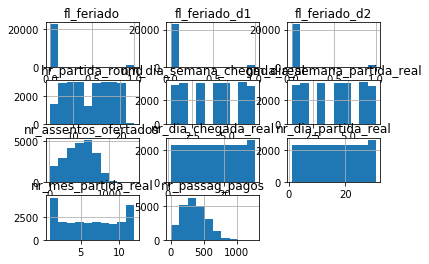

In [94]:
df_sp_grouped.hist();

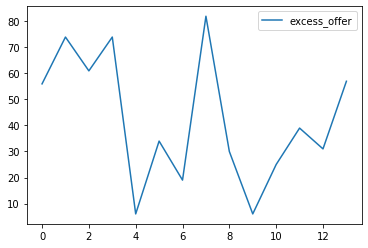

In [122]:
df_sp_grouped.query("'2019-06-01' <=dt_partida_real <= '2019-06-01' ").reset_index()[['excess_offer']].plot()

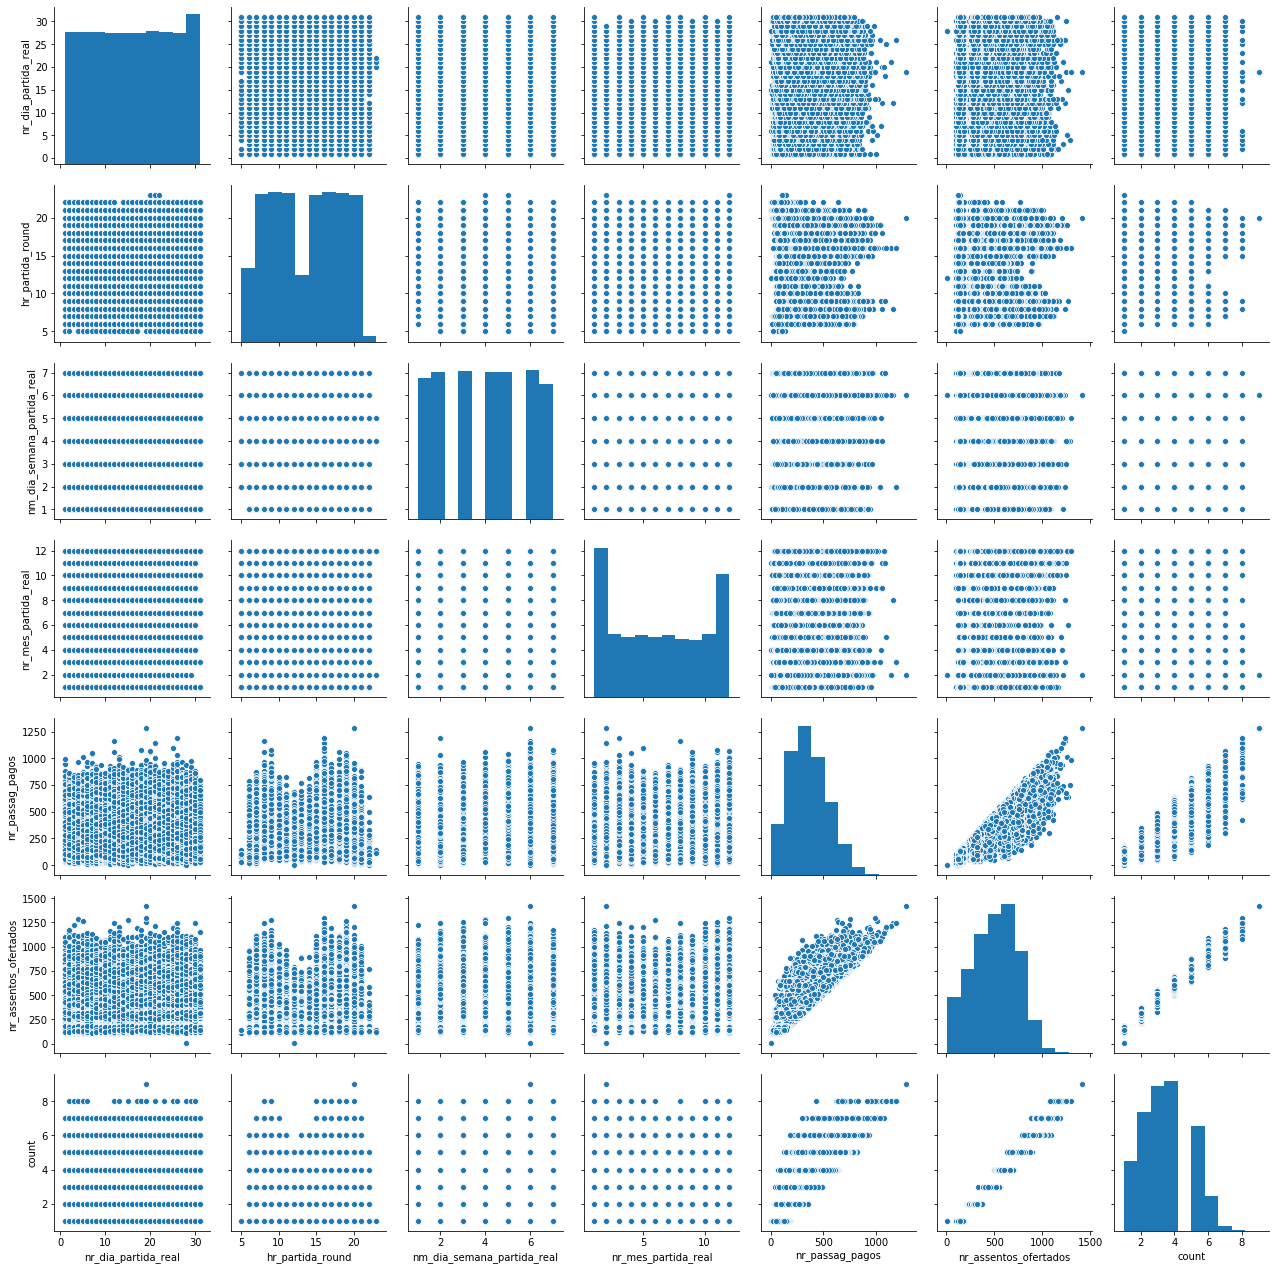

In [49]:
sns.pairplot(df_sp_grouped[['nr_dia_partida_real','hr_partida_round','nm_dia_semana_partida_real','nr_mes_partida_real','nr_passag_pagos','nr_assentos_ofertados','count']]);

# Modeling

## Random Forests

In [14]:
X = df_sp_grouped.drop(['nr_passag_pagos','dt_partida_real','excess_offer'],axis=1)
y = df_sp_grouped.nr_passag_pagos

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [15]:
X.head()

,nr_dia_partida_real,nm_dia_semana_partida_real,nr_mes_partida_real,nr_dia_chegada_real,nm_dia_semana_chegada_real,hr_partida_round,fl_feriado,fl_feriado_d1,fl_feriado_d2,nr_assentos_ofertados,count
0,1.0,1,1.0,1.0,1,8,1.0,0.0,0.0,177,1
1,1.0,1,1.0,1.0,1,9,1.0,0.0,0.0,441,3
2,1.0,1,1.0,1.0,1,10,1.0,0.0,0.0,465,3
3,1.0,1,1.0,1.0,1,11,1.0,0.0,0.0,321,2
4,1.0,1,1.0,1.0,1,12,1.0,0.0,0.0,276,2


In [16]:
if training:

    rf = RandomForestRegressor(random_state=seed, n_jobs=-1)

    param_grid = {'n_estimators' : [700,750,800],
                  'max_depth' : [3,6,15],
                  'max_features':['auto']}

    grid = GridSearchCV(rf, param_grid=param_grid, cv=5,return_train_score = True,scoring = 'neg_mean_absolute_error').fit(X_train, y_train)
    
    #neg_root_mean_squared_error
    reg_rf = grid.best_estimator_.fit(X_train,y_train)

    print(grid.best_params_)
   # print(grid.cv_results_)

{'max_depth': 15, 'max_features': 'auto', 'n_estimators': 800}


In [23]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_rf.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_rf.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, reg_rf.predict(X_train))))
print("train MAPE: {:.2f}%".format(MAPE(y_test, reg_rf.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, reg_rf.predict(X_train))**0.5))
print("train RMSE: {:.2f}".format(mean_squared_error(y_test, reg_rf.predict(X_test))**0.5))

train MAE: 27.61
test MAE: 47.64
train MAPE: 9.40%
train MAPE: 18.13%
train RMSE: 37.48
train RMSE: 65.61


In [107]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_rf.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_rf.predict(X_test))))
print("train MAPE: {:.2f}%".format(100*MAPE(y_train, reg_rf.predict(X_train))))
print("train MAPE: {:.2f}%".format(100*MAPE(y_test, reg_rf.predict(X_test))))

train MAE: 29.50
test MAE: 50.66
train MAPE: 20.43%
train MAPE: 35.04%


In [100]:
grid.cv_results_

{'mean_fit_time': array([3.9694047 , 5.86669378, 6.16200819, 6.65363369, 4.94314547,
        7.28322763, 8.21678638, 8.55168667, 5.45420442, 8.18837199,
        9.20925536, 9.99621   ]),
 'std_fit_time': array([0.10864231, 0.29145584, 0.18212427, 0.14552156, 0.0150986 ,
        0.32635278, 0.47927984, 0.24289485, 0.03200958, 0.23702988,
        0.49072141, 0.63087937]),
 'mean_score_time': array([0.20490799, 0.20414195, 0.2047986 , 0.20385513, 0.20484328,
        0.20463133, 0.26510029, 0.30487533, 0.20443954, 0.32533946,
        0.34735923, 0.36547127]),
 'std_score_time': array([3.06188445e-04, 5.30780838e-04, 3.92909351e-04, 5.43789026e-04,
        8.02568628e-04, 1.75638876e-03, 8.23131356e-02, 7.39810046e-05,
        3.56565251e-04, 4.05007332e-02, 5.24547507e-02, 4.97553038e-02]),
 'param_max_depth': masked_array(data=[12, 12, 12, 12, 15, 15, 15, 15, 17, 17, 17, 17],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, Fals

## Gradient Boosting sklearn

In [70]:
if training:
    gb = GradientBoostingRegressor(random_state=seed)
    
    param_grid = {'n_estimators': [2300,2500,2800], 
                     'max_depth': [7,8],
             'min_samples_split': [2],
                 'learning_rate': [0.01],
                          'loss': ['ls']}
    
    grid = GridSearchCV(gb, param_grid=param_grid, cv=5,return_train_score = True).fit(X_train, y_train)

    reg_gb = grid.best_estimator_.fit(X_train,y_train)

    print(grid.best_params_)
   # print(grid.cv_results_)

{'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 2800}


In [71]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_gb.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_gb.predict(X_test))))
print("train MAPE: {:.2f}%".format(100*MAPE(y_train, reg_gb.predict(X_train))))
print("train MAPE: {:.2f}%".format(100*MAPE(y_test, reg_gb.predict(X_test))))

train MAE: 27.37
test MAE: 41.90
train MAPE: 18.96%
train MAPE: 28.98%


## XGBoosting

In [74]:
if training:

    reg_xgb = xgb.XGBRegressor()

    param_grid = { 'learning_rate': [0.01, 0.05], #so called `eta` value
                         'max_depth': [6, 7, 8],
                      'n_estimators': [2300,2500,2800]}

    grid = GridSearchCV(reg_xgb, param_grid=param_grid, cv=5,return_train_score = True).fit(X_train, y_train)

    reg_xgb = grid.best_estimator_.fit(X_train,y_train)

    print(grid.best_params_)
   # print(grid.cv_results_)

[20:02:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:02:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:03:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:03:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[20:36:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:36:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:37:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:37:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:38:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:39:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:40:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [75]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_xgb.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_xgb.predict(X_test))))
print("train MAPE: {:.2f}%".format(100*MAPE(y_train, reg_xgb.predict(X_train))))
print("train MAPE: {:.2f}%".format(100*MAPE(y_test, reg_xgb.predict(X_test))))

train MAE: 21.07
test MAE: 41.30
train MAPE: 14.59%
train MAPE: 28.56%


# Feriados d-1

In [46]:
X = data_grouped.drop(['nr_passag_pagos','dt_partida_real','nr_assentos_ofertados'],axis=1)
y = data_grouped.nr_passag_pagos

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

NameError: name 'data_grouped' is not defined

In [13]:
if training:

    rf = RandomForestRegressor(random_state=seed, n_jobs=-1)

    param_grid = {'n_estimators' : [500,600],
                  'max_depth' : [20,30],
                  'max_features':['auto']}

    grid = GridSearchCV(rf, param_grid=param_grid, cv=5,return_train_score = True).fit(X_train, y_train)

    reg_rf = grid.best_estimator_.fit(X_train,y_train)

    print(grid.best_params_)
    print(grid.cv_results_)

{'max_depth': 20, 'max_features': 'auto', 'n_estimators': 600}
{'mean_fit_time': array([ 8.42685008,  9.8788115 ,  9.40908051, 11.22145987]), 'std_fit_time': array([0.61023936, 0.1064249 , 0.04604737, 0.09600827]), 'mean_score_time': array([0.20400319, 0.304563  , 0.30462289, 0.30411201]), 'std_score_time': array([0.00161617, 0.00048201, 0.00049977, 0.00067279]), 'param_max_depth': masked_array(data=[20, 20, 30, 30],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_features': masked_array(data=['auto', 'auto', 'auto', 'auto'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[500, 600, 500, 600],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 20, 'max_features': 'auto', 'n_estimators': 500}, {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 600}, {'max_dept

In [ ]:
print("train MAE: {}".format(mean_absolute_error(y_train,reg_rf.predict(X_train))))
print("test MAE: {}".format(mean_absolute_error(y_test,reg_rf.predict(X_test))))

train MAPE: 6.56346858417654
train MAPE: 9.822700996039767


In [40]:
X_test['excess_offer'] = y_test

/home/welberth/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
y_train.describe()

count    15792.000000
mean       359.458143
std        179.797972
min          5.000000
25%        227.000000
50%        345.000000
75%        481.000000
max       1279.000000
Name: nr_passag_pagos, dtype: float64